In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

# Problem setup

We will assume an experiment based on $^{100}\text{Mo}$ and with the following parameters:

- $468~\text{kg}$ of total detector mass
- $250~\text{kg}$ of $^{100}\text{Mo}$ isotope, with a $2\nu\beta\beta$ halflife of $T_{1/2} = 7.12 \cdot 10^{18}~\text{yr}$
- A true halflife of $5 \cdot 10^{23}~\text{yr}$ for the $0\nu\beta\beta$ decay with Majoron emission
- $100\%$ total efficiency
- Energy threshold $30~\text{keV}$ (ignore everything that is below)
- $\Delta t_{exp} = 5~\text{yr}$ of measurement time

$Q_{\beta \beta} = 3034~\text{keV}$


In [2]:
M_DETECTOR_KG = 468
M_100MO_KG = 250
HALFTIME_2NUBB_YR = 7.12e18
HALFTIME_0NUBB_YR = 5e23
E_THRESHOLD_MEV = 30 / 1000
EXP_TIME_YR = 5

Q_BETA_BETA_MEV = 3.034

MC_BIN_SIZE = 5e-3
MC_BIN_EDGES = np.arange(
    start=E_THRESHOLD_MEV,
    stop=Q_BETA_BETA_MEV + 0.1,
    step=MC_BIN_SIZE,
)

In [3]:
import dataclasses


def bin_sizes_from_centers(bin_centers: np.ndarray) -> np.ndarray:
    assert len(bin_centers.shape) == 1
    deltas = bin_centers[1:] - bin_centers[:-1]
    sizes = np.zeros(shape=(bin_centers.size,))
    sizes[0] = deltas[0]
    sizes[-1] = deltas[-1]
    sizes[1:-1] = 0.5 * (deltas[1:] + deltas[:-1])
    return sizes


# def normalize_to_pdf


@dataclasses.dataclass
class Spectrum:
    energy: np.ndarray
    pdf: np.ndarray

    def __post_init__(self) -> None:
        self.bin_sizes = bin_sizes_from_centers(self.energy)
        self.cdf = np.cumsum(self.pdf * self.bin_sizes)

    def generate_sample(self, size: int) -> np.ndarray:
        cdf_image = np.sort(np.random.uniform(low=0, high=1, size=size))
        return np.interp(cdf_image, self.cdf, self.energy)

    def rebinned(self, bin_edges: np.ndarray) -> "Spectrum":
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        bin_edge_values = np.interp(
            bin_edges,
            self.energy,
            self.pdf,
            left=0,
            right=0,
        )
        # assuming linearity within one bin -- will work only with small enough bins, but ok for us
        bin_average_probabilities = 0.5 * (bin_edge_values[1:] + bin_edge_values[:-1])
        return Spectrum(energy=bin_centers, pdf=bin_average_probabilities)

    def generate_histogram(
        self,
        total_count: float,
    ) -> np.ndarray:
        bin_average_counts = self.pdf * self.bin_sizes * total_count
        return np.random.poisson(lam=bin_average_counts)

    @classmethod
    def from_counts(cls, energy: np.ndarray, counts: np.ndarray) -> "Spectrum":
        probability = counts / (counts * bin_sizes_from_centers(energy)).sum()
        return Spectrum(energy=energy, pdf=probability)

    @classmethod
    def load(cls, filename: str) -> "Spectrum":
        raw = np.loadtxt(filename, skiprows=1)
        assert raw.shape[1] == 3
        energy = raw[:, 0] / 1000
        dnde = raw[:, 1]
        return Spectrum.from_counts(energy=energy, counts=dnde)


@dataclasses.dataclass
class DoubleElectronSpectrum:
    pdf: np.ndarray  # 2 dim
    x_energy: np.ndarray  # 1 dim
    y_energy: np.ndarray  # 1 dim

    def sum_spectrum(self) -> Spectrum:
        sum_binning_step = 5e-3

        e_min = np.inf
        e_max = 0.0
        it = np.nditer(self.pdf, flags=["multi_index"])
        for prob in it:
            idx_x, idx_y = it.multi_index
            if prob < 0:
                continue
            e = float(self.x_energy[idx_x] + self.y_energy[idx_y])
            e_min = min(e_min, e)
            e_max = max(e_max, e)

        assert np.isfinite(e_min)
        assert np.isfinite(e_max)
        assert e_min < e_max
        range_ = e_max - e_min
        e_bin_edges = np.arange(
            e_min - (range_ * 1e-3),
            e_max + sum_binning_step + (range_ * 1e-3),
            sum_binning_step,
        )
        e_bin_centers = 0.5 * (e_bin_edges[1:] + e_bin_edges[:-1])
        histogram = np.zeros_like(e_bin_centers)

        it = np.nditer(self.pdf, flags=["multi_index"])
        for prob in it:
            idx_x, idx_y = it.multi_index
            if prob < 0:
                continue
            e = self.x_energy[idx_x] + self.y_energy[idx_y]
            e_idx = np.digitize(e, e_bin_edges)
            histogram[e_idx] += prob

        return Spectrum.from_counts(energy=e_bin_centers, counts=histogram)

    def plot(self, title: str) -> None:
        fig, ax = plt.subplots()
        ax: plt.Axes

        img = ax.imshow(self.pdf, origin="lower", cmap="inferno")

        x_ticks = np.linspace(0, self.pdf.shape[0] - 1, 5, dtype="int")
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(
            labels=["{:.2f}".format(self.x_energy[idx]) for idx in x_ticks]
        )
        ax.set_xlabel("$ \epsilon_1,  \\text{MeV} $")

        y_ticks = np.linspace(0, self.pdf.shape[1] - 1, 5, dtype="int")
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(
            labels=["{:.2f}".format(self.y_energy[idx]) for idx in y_ticks]
        )
        ax.set_ylabel("$ \epsilon_2, \\text{MeV} $")

        ax.axvline(E_THRESHOLD_MEV, color="red", linestyle="--", label="Threshold")
        ax.axhline(E_THRESHOLD_MEV, color="red", linestyle="--")

        ax.set_title(title)

        fig.colorbar(img, label="PDF")

    @classmethod
    def load(cls, filename: str) -> "DoubleElectronSpectrum":
        """
        Legend:
        - Column 1, 2 → Bin index for x and y directions.
        - Column 3, 4 → Bin center along x and y direction, corresponding to energy of first and second electron.
        - Column 5 → Probability content for the bin.
        """
        raw = np.loadtxt(filename)
        assert raw.shape[1] == 5
        x_min = int(raw[:, 0].min())
        x_max = int(raw[:, 0].max())
        y_min = int(raw[:, 1].min())
        y_max = int(raw[:, 1].max())

        probability_map = np.zeros(shape=(x_max - x_min + 1, y_max - y_min + 1))
        x_energy = np.zeros(shape=(x_max - x_min + 1))
        y_energy = np.zeros(shape=(y_max - y_min + 1))

        for x_idx, y_idx, x_e, y_e, prob in raw:
            x_idx = int(x_idx) - x_min
            y_idx = int(y_idx) - y_min
            probability_map[x_idx, y_idx] = prob
            x_energy[x_idx] = x_e
            y_energy[y_idx] = y_e

        # normalizing to integral 1
        probability_map /= (
            probability_map
            * np.tile(
                bin_sizes_from_centers(x_energy).reshape((-1, 1)),
                (1, y_max - y_min + 1),
            )
            * np.tile(
                bin_sizes_from_centers(y_energy).reshape((1, -1)),
                (x_max - x_min + 1, 1),
            )
        ).sum()

        return DoubleElectronSpectrum(probability_map, x_energy, y_energy)

# Theoretical description

## Physical background

$2\nu\beta\beta$ events, distributed as a continuum between 0 and the Q-value (3034 keV).


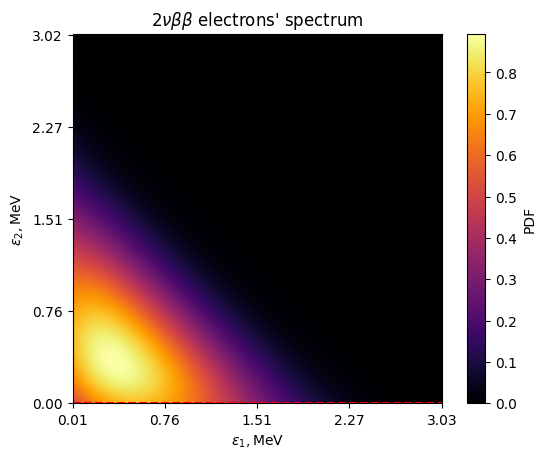

In [8]:
double_bb_2d = DoubleElectronSpectrum.load("data/100Mo_ssd_2ds.txt")
double_bb_2d.plot(title="$ 2 \\nu \\beta \\beta $ electrons' spectrum")
double_bb = double_bb_2d.sum_spectrum().rebinned(MC_BIN_EDGES)

## Signal

Majoron events, distributed as a continuum, but with a different distribution than 2νββ events.


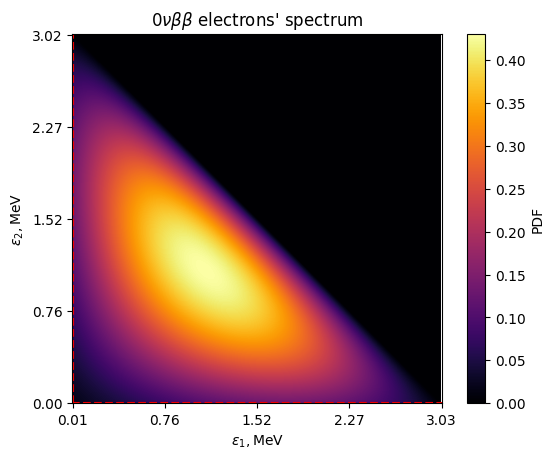

In [9]:
majoron_2d = DoubleElectronSpectrum.load("data/m1_2ds.dat")
majoron_2d.plot(title="$ 0 \\nu \\beta \\beta $ electrons' spectrum")
majoron = majoron_2d.sum_spectrum().rebinned(MC_BIN_EDGES)

## $\beta$-decay background

A contamination of $^{90} \text{Sr}$ and $^{90}\text{Y}$, both of which are $\beta$ emitters. We assume them to be in secular equilibrium with an activity of $(3.4 \pm 0.4) \cdot 10^{-4}~\mathrm{Bq~kg^{-1}}$ (here we are referring to the total detector mass), meaning that we measure the same event rate for the two of them.


In [6]:
BETA_BACKGROUND_ACTIVITY_MEAN = 3.4e-4
BETA_BACKGROUND_ACTIVITY_STD = 0.4e-4
SEC_PER_YEAR = 365 * 86400

sr_beta = Spectrum.load("data/90Sr-beta-decay.txt").rebinned(MC_BIN_EDGES)
y_beta = Spectrum.load("data/90Y-beta-decay.txt").rebinned(MC_BIN_EDGES)

## All components spectra


In [7]:
SR_BETA_PLOT_KW = dict(label="$^{90} \\text{Sr}$ $ \\beta $-decay", color="magenta")
Y_BETA_PLOT_KW = dict(label="$^{90} \\text{Y}$ $ \\beta $-decay", color="green")
DOUBLE_BB_PLOT_KW = dict(label="$2\\nu \\beta \\beta$", color="blue")
MAJORON_PLOT_KW = dict(label="$0\\nu \\beta \\beta$", color="orange")

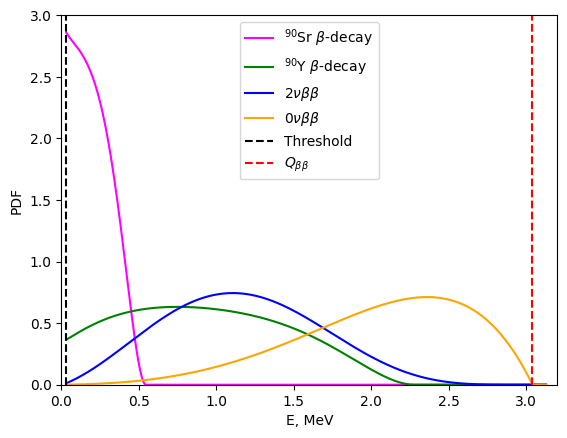

In [8]:
fig, ax = plt.subplots()

ax.plot(sr_beta.energy, sr_beta.pdf, **SR_BETA_PLOT_KW)
ax.plot(y_beta.energy, y_beta.pdf, **Y_BETA_PLOT_KW)
ax.plot(double_bb.energy, double_bb.pdf, **DOUBLE_BB_PLOT_KW)
ax.plot(majoron.energy, majoron.pdf, **MAJORON_PLOT_KW)

ax.axvline(E_THRESHOLD_MEV, color="black", linestyle="--", label="Threshold")
ax.axvline(Q_BETA_BETA_MEV, color="red", linestyle="--", label="$Q_{\\beta \\beta}$")

ax.set_xlabel("E, MeV")
ax.set_ylabel("PDF")
ax.set_ylim(bottom=0)
ax.set_xlim(left=0, right=3.2)
ax.legend()
plt.show()

# Monte-Carlo simulation

## Average event number

Molybdenum decay

- Radioactive decay law: $N_{nucl}(t) = N_0 \cdot 2^{t / T_{1/2}}$
- From this, **average number of decays**: $N(t) = N_0 \left( 1 - 2^{t / T_{1/2}} \right)$
- $N(t) \approx N_0 \ln 2 \frac{t}{T_{1/2}}$ for $t \ll T_{1/2}$, which is true in our case

$\beta$-decay background

- Assuming constant activity, we simply get $N = A \cdot M \cdot t$


In [9]:
N_A = 6.022e23
MOLAR_MASS_100M_KG_MOL = 100 / 1000
N0_100Mo = N_A * M_100MO_KG / MOLAR_MASS_100M_KG_MOL

N_double_bb: float = N0_100Mo * np.log(2) * EXP_TIME_YR / HALFTIME_2NUBB_YR
N_majoron: float = N0_100Mo * np.log(2) * EXP_TIME_YR / HALFTIME_0NUBB_YR


def generate_beta_backgrounds() -> tuple[float, float]:
    return tuple(
        np.random.normal(
            loc=BETA_BACKGROUND_ACTIVITY_MEAN,
            scale=BETA_BACKGROUND_ACTIVITY_STD,
            size=2,
        )
        * M_DETECTOR_KG
        * EXP_TIME_YR
        * SEC_PER_YEAR
    )


print("Signals:")
print(f"{N_double_bb = :.2e}")
print(f"{N_majoron = :.2e}")
print()

N_sr_y_beta_mean = (
    BETA_BACKGROUND_ACTIVITY_MEAN * M_DETECTOR_KG * EXP_TIME_YR * SEC_PER_YEAR
)
N_sr_y_beta_std = (
    BETA_BACKGROUND_ACTIVITY_STD * M_DETECTOR_KG * EXP_TIME_YR * SEC_PER_YEAR
)
print(f"Background: {N_sr_y_beta_mean:.2e} +/- {N_sr_y_beta_std:.2e}")
print()
print("Example background realization:")
N_sr_beta_rlz, N_y_beta_rlz = generate_beta_backgrounds()
print(f"{N_sr_beta_rlz = :.2e}")
print(f"{N_y_beta_rlz = :.2e}")

Signals:
N_double_bb = 7.33e+08
N_majoron = 1.04e+04

Background: 2.51e+07 +/- 2.95e+06

Example background realization:
N_sr_beta_rlz = 2.30e+07
N_y_beta_rlz = 2.23e+07


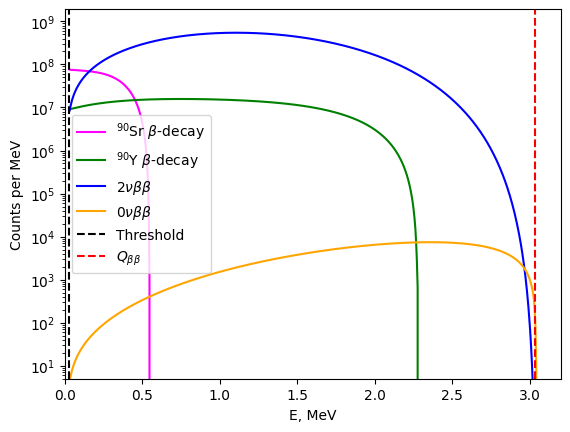

In [10]:
fig, ax = plt.subplots()

N_sr_beta_rlz, N_y_beta_rlz = generate_beta_backgrounds()
ax.plot(sr_beta.energy, N_sr_beta_rlz * sr_beta.pdf, **SR_BETA_PLOT_KW)
ax.plot(y_beta.energy, N_y_beta_rlz * y_beta.pdf, **Y_BETA_PLOT_KW)
ax.plot(double_bb.energy, N_double_bb * double_bb.pdf, **DOUBLE_BB_PLOT_KW)
ax.plot(majoron.energy, N_majoron * majoron.pdf, **MAJORON_PLOT_KW)

ax.axvline(E_THRESHOLD_MEV, color="black", linestyle="--", label="Threshold")
ax.axvline(Q_BETA_BETA_MEV, color="red", linestyle="--", label="$Q_{\\beta \\beta}$")

ax.set_xlabel("E, MeV")
ax.set_ylabel("Counts per MeV")
ax.set_yscale("log")
ax.set_ylim(5)
ax.set_xlim(left=0, right=3.2)
ax.legend()
plt.show()

## Experimental data generation


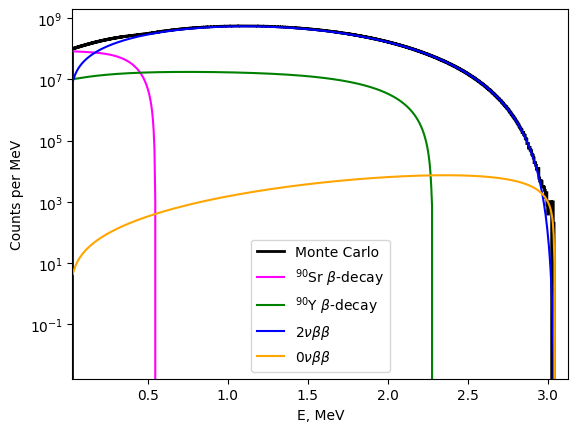

In [11]:
def generate_data() -> tuple[np.ndarray, float, float]:
    N_sr_beta_rlz, N_y_beta_rlz = generate_beta_backgrounds()

    histogram = np.zeros(shape=(MC_BIN_EDGES.size - 1))
    for N_events, spectrum in zip(
        [N_double_bb, N_majoron, N_sr_beta_rlz, N_y_beta_rlz],
        [double_bb, majoron, sr_beta, y_beta],
    ):
        histogram += spectrum.generate_histogram(total_count=N_events)

    return histogram, N_sr_beta_rlz, N_y_beta_rlz


histogram, N_sr_beta_rlz, N_y_beta_rlz = generate_data()

fig, ax = plt.subplots()
ax: plt.Axes

ax.stairs(
    histogram / MC_BIN_SIZE,  # counts -> counts per mev conversion
    MC_BIN_EDGES,
    label="Monte Carlo",
    linewidth=2,
    color="black",
)

ax.plot(sr_beta.energy, N_sr_beta_rlz * sr_beta.pdf, **SR_BETA_PLOT_KW)
ax.plot(y_beta.energy, N_y_beta_rlz * y_beta.pdf, **Y_BETA_PLOT_KW)
ax.plot(double_bb.energy, N_double_bb * double_bb.pdf, **DOUBLE_BB_PLOT_KW)
ax.plot(majoron.energy, N_majoron * majoron.pdf, **MAJORON_PLOT_KW)

ax.legend()

ax.set_xlabel("E, MeV")
ax.set_ylabel("Counts per MeV")
ax.set_yscale("log")
ax.set_xlim(MC_BIN_EDGES[0], MC_BIN_EDGES[-1])
ax.legend()
plt.show()

# Bayesian analysis

## Posterior sampling routine

Based on `emcee` sampler.


In [12]:
from scipy import stats
import emcee
import corner

## Analysis 1: theoretical spectra are exactly known

### Posterior probability

- Parameter vector consists of event numbers for each spectral component: $\vec \theta = (N_{2\nu\beta\beta}, N_{maj}, N_{Sr}, N_{Y})$
- Binned likelihood ($i = 1..K$ - bin index): $\mathcal L = \prod_{i=1}^{K} \text{Poisson}(n_i, \lambda_i(\theta))$
- Prior is separable $\pi(\vec \theta) = \pi(N_{2\nu\beta\beta}) \cdot \pi(N_{maj}) \cdot \pi(N_{Sr}) \cdot \pi(N_{Y})$
  - $\pi(N_{2\nu\beta\beta}) = \pi(N_{maj}) = \mathcal U (0, 10^{9})$
  - $\pi(N_{Sr}) = \pi(N_{Y}) = \mathcal N (2.5 \cdot 10^7, 2.95 \cdot 10^6)$
- Posterior probability is given by $p(\vec \theta | n) \propto \mathcal L (n | \vec \theta) \pi ( \vec \theta )$
- In practice, logarithms are used instead of direct PDF.


In [13]:
def log_prior_1(theta: np.ndarray):
    N_double_bb, N_majoron, N_sr_beta, N_y_beta = theta
    return (
        stats.uniform.logpdf(N_double_bb, loc=0, scale=1e9)
        + stats.uniform.logpdf(N_majoron, loc=0, scale=1e9)
        + stats.norm.logpdf(N_sr_beta, loc=N_sr_y_beta_mean, scale=N_sr_y_beta_std)
        + stats.norm.logpdf(N_y_beta, loc=N_sr_y_beta_mean, scale=N_sr_y_beta_std)
    )


def log_posterior_1(theta: np.ndarray, histogram: np.ndarray):
    logpi = log_prior_1(theta)
    if np.isfinite(logpi):
        lambdas = np.zeros_like(histogram)
        for N_component, spectrum in zip(theta, [double_bb, majoron, sr_beta, y_beta]):
            lambdas += N_component * spectrum.pdf * spectrum.bin_sizes
        loglike = stats.poisson.logpmf(histogram, np.clip(lambdas, 0, None)).sum()
        if np.isnan(loglike):
            print(theta)
            raise RuntimeError()
        return logpi + loglike
    else:
        return logpi

### Sampling and results


In [14]:
histogram, N_sr_beta_rlz, N_y_beta_rlz = generate_data()

n_walkers = 64
n_dim = 4
sampler = emcee.EnsembleSampler(
    nwalkers=n_walkers,
    ndim=n_dim,
    log_prob_fn=log_posterior_1,
    args=[histogram],
)

total_events = np.sum(histogram)
# assuming that most events come from 2-neutrino beta decay
initial_theta_mean = np.array(
    [
        total_events,
        total_events * 1e-4,
        N_sr_y_beta_mean,
        N_sr_y_beta_mean,
    ]
)
initial_theta_std = np.array(
    [
        total_events * 0.1,
        total_events * 1e-5,
        2 * N_sr_y_beta_std,
        2 * N_sr_y_beta_std,
    ]
)
initial_state = stats.norm.rvs(
    loc=initial_theta_mean, scale=initial_theta_std, size=(n_walkers, 4)
)

print("Sampling...")
sampler.run_mcmc(initial_state, nsteps=7000, progress=True)
print(f"{sampler.acceptance_fraction.mean() = }")
tau = sampler.get_autocorr_time()
print(f"{tau = }")
burn_in = 3 * int(tau.max())
thin = int(tau.max())
print(f"{burn_in = } {thin = }")
sample: np.ndarray = sampler.get_chain(flat=True, discard=burn_in, thin=thin)
print(f"Sample ready, shape: {sample.shape}")

Sampling...


100%|██████████| 7000/7000 [01:07<00:00, 103.42it/s]


sampler.acceptance_fraction.mean() = 0.5899910714285714
tau = array([17.76350958, 82.10040799, 25.74569052, 31.09989566])
burn_in = 246 thin = 82
Sample ready, shape: (5248, 4)


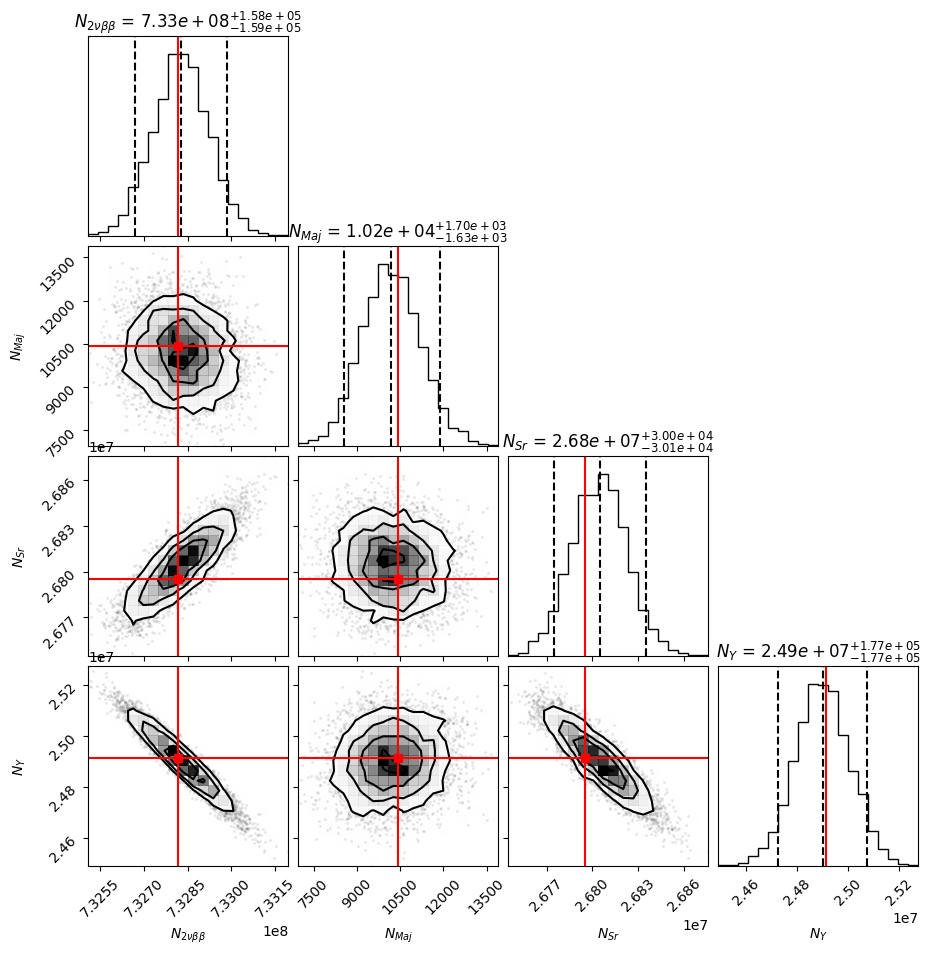

In [15]:
_ = corner.corner(
    sample,
    labels=["$N_{2\\nu\\beta\\beta}$", "$N_{Maj}$", "$N_{Sr}$", "$N_{Y}$"],
    truths=[N_double_bb, N_majoron, N_sr_beta_rlz, N_y_beta_rlz],
    truth_color="red",
    show_titles=True,
    title_fmt=".2e",
    quantiles=[0.05, 0.5, 0.95],
)

## Analysis 2: theoretical spectra are accessible only through finite-size Monte-Carlo


### Monte-Carlo spectra approximations


In [16]:
# MC statistic should correspond to 100 yrs of data taking
mc_time_factor = 100 / EXP_TIME_YR

double_bb_mc = double_bb.generate_histogram(total_count=N_double_bb * mc_time_factor)
majoron_mc = majoron.generate_histogram(total_count=N_majoron * mc_time_factor)
# for Sr/Y we just use mean event counts because uncertainty in them
# is accounted for in the fit already, here we only need spectral shape
sr_beta_mc = sr_beta.generate_histogram(total_count=N_sr_y_beta_mean * mc_time_factor)
y_beta_mc = y_beta.generate_histogram(total_count=N_sr_y_beta_mean * mc_time_factor)

spectrum_len = double_bb_mc.size
assert majoron_mc.size == spectrum_len
assert sr_beta_mc.size == spectrum_len
assert y_beta_mc.size == spectrum_len

### Posterior probability

We want to perform simultaneous fit of event counts and true spectral shapes for each component.
Data now include both (simulated) experimental data and (simulated) Monte-Carlo for each components,
that will provide constraints for the true spectral shape.

- Parameter vector $\vec \theta$ will now contain $4 + 4 \cdot 620 = 2484$ numbers:
  - Our 4 parameters of interest $N_{2\nu\beta\beta}, \; N_{maj}, \; N_{Sr}, \; N_{Y}$
  - For each $k=1..4$ spectral component, $j=1..620$ numbers $\lambda_{kj}$ for true spectral PDF
    in each energy bin
  - Poissonian prior is defined only for $\lambda_{ki} > 0 \quad \forall k, i$
    - We cannot add this constraint directly to prior. If we do so, then $\lambda_{ki} < 0$ for at least one $k, i$
      will lead to $\pi(\vec \theta) = 0$, and MCMC step, based on probability ratio, will be impossible.
      Since there is 2480 $\lambda_{ki}$ parameters, the chance of at least one of them being negative
      is very high, which makes the whole MCMC sampling impossibl.
    - One option is to add this non-negativity constrain iimplicitly, through the change of variables
      $\eta_i \equiv \log \lambda_i$.  The prior must account for this change of variable through a Jacobian
      (leaving out index $ki$ for brevity):
      $\pi_{\eta}(\eta) = \pi_{\lambda}(\lambda) \frac{d \lambda}{d \eta} = \pi_{\lambda}(e^\eta) \cdot e^\eta$
    - Another option is to allow sampler to explore negative values $\lambda_{ki}$, but clamp them to 0 before
      computing Poissonian priors. In this case the prior will be padded with it's value at zero to all negative
      values. We can prevent that by adding an ad-hoc penalty for negative weight in the form of Gaussian decline.
      This can be viewed as "smoothing out" of true condition $\lambda_{ki} < 0 \Rightarrow \pi(\lambda_{ki}) = 0$.
      Also, in practice clamping is done not to 0 but to some small $\varepsilon$, as $\lambda_{ki} = 0$ leads to
      $\pi = 0$ for any non-zero number of counts.
- Priors are again separable
  - For 4 main parameters, same priors as in first analysis
  - For each spectral component, we use Poissonian prior to produce MC spectra counts. Mean value is $\mu_{kj} = \lambda_{kj} \cdot \Delta E \cdot N_{k}^{(MC)}$, where $\Delta E$ is energy bin size, $N_{k}^{(MC)}$ is MC sample size for $k$-th component
- Finally, likelihood is the same as in first analysis, but instead of using theoretical spectra PDF, it uses
  values extracted from the parameter vector.

In [17]:
PDF_VALUE_EPSILON = 1e-20


def clip_pdf(pdf: np.ndarray) -> np.ndarray:
    return np.clip(pdf, PDF_VALUE_EPSILON, None)


USE_LOGPDF = False


def params_to_pdf(params: np.ndarray) -> np.ndarray:
    return np.exp(params) if USE_LOGPDF else params


b0 = 4
b1 = 4 + 1 * spectrum_len
b2 = 4 + 2 * spectrum_len
b3 = 4 + 3 * spectrum_len
b4 = 4 + 4 * spectrum_len
double_bb_mc_norm = double_bb.bin_sizes * N_double_bb * mc_time_factor
majoron_mc_norm = majoron.bin_sizes * N_majoron * mc_time_factor
sr_beta_mc_norm = sr_beta.bin_sizes * N_sr_y_beta_mean * mc_time_factor
y_beta_mc_norm = y_beta.bin_sizes * N_sr_y_beta_mean * mc_time_factor


@dataclasses.dataclass
class Params:
    N_double_bb: float
    N_majoron: float
    N_sr_beta: float
    N_y_beta: float
    double_bb_pdf: np.ndarray
    majoron_pdf: np.ndarray
    sr_beta_pdf: np.ndarray
    y_beta_pdf: np.ndarray

    @property
    def pdfs(self) -> list[np.ndarray]:
        return [self.double_bb_pdf, self.majoron_pdf, self.sr_beta_pdf, self.y_beta_pdf]

    @staticmethod
    def unpack(theta: np.ndarray) -> "Params":
        assert theta.shape == (2484,)
        return Params(
            *theta[0:4],
            # eta -> lambda by exponentiation
            params_to_pdf(theta[b0:b1]),
            params_to_pdf(theta[b1:b2]),
            params_to_pdf(theta[b2:b3]),
            params_to_pdf(theta[b3:b4]),
        )


def log_prior_2(params: Params):
    jacobian = (
        # lambda -> eta jacobian, see above
        sum(np.log(pdf).sum() for pdf in params.pdfs)
        if USE_LOGPDF
        else 0
    )
    ad_hoc_penalization = (
        0
        if USE_LOGPDF
        else sum(
            stats.expon.logpdf(
                # penalizing negative PDF values with exponentially decaying probability
                -pdf[pdf < PDF_VALUE_EPSILON],
                loc=PDF_VALUE_EPSILON,
                scale=1e-15,
            ).sum()
            for pdf in params.pdfs
        )
    )
    return (
        # first 4 param priors
        stats.uniform.logpdf(params.N_double_bb, loc=0, scale=1e9)
        + stats.uniform.logpdf(params.N_majoron, loc=0, scale=1e9)
        + stats.norm.logpdf(
            params.N_sr_beta, loc=N_sr_y_beta_mean, scale=N_sr_y_beta_std
        )
        + stats.norm.logpdf(
            params.N_y_beta, loc=N_sr_y_beta_mean, scale=N_sr_y_beta_std
        )
        # priors for spectral shapes, summed across all energy bins
        # PDFs are clipped at (almost) zero to ensure they lead to valid Poissonian lambdas
        + stats.poisson.logpmf(
            double_bb_mc,
            clip_pdf(params.double_bb_pdf) * double_bb_mc_norm,
        ).sum()
        + stats.poisson.logpmf(
            majoron_mc,
            clip_pdf(params.majoron_pdf) * majoron_mc_norm,
        ).sum()
        + stats.poisson.logpmf(
            sr_beta_mc,
            clip_pdf(params.sr_beta_pdf) * sr_beta_mc_norm,
        ).sum()
        + stats.poisson.logpmf(
            y_beta_mc,
            clip_pdf(params.y_beta_pdf) * y_beta_mc_norm,
        ).sum()
        + jacobian
        + ad_hoc_penalization
    )


def log_posterior_2(theta: np.ndarray, histogram: np.ndarray):
    params = Params.unpack(theta)
    logpi = log_prior_2(params)
    if np.isfinite(logpi):
        lambdas = np.zeros_like(histogram)
        for N_component, pdf, true_spectrum in (
            (
                params.N_double_bb,
                params.double_bb_pdf,
                double_bb,
            ),
            (
                params.N_majoron,
                params.majoron_pdf,
                majoron,
            ),
            (
                params.N_sr_beta,
                params.sr_beta_pdf,
                sr_beta,
            ),
            (
                params.N_y_beta,
                params.y_beta_pdf,
                y_beta,
            ),
        ):
            lambdas += N_component * clip_pdf(pdf) * true_spectrum.bin_sizes
        loglike = stats.poisson.logpmf(histogram, lambdas).sum()
        return logpi + loglike
    else:
        return logpi

## Sampling

In [30]:
EPSILON = 1e-15


def pdf_mean_std(mc: np.ndarray, norm: np.ndarray):
    pdf_mean = mc / norm + EPSILON  # avoid exact zeroes
    pdf_std = np.sqrt(mc) / norm + EPSILON  # avoid exact zeroes
    return pdf_mean, pdf_std


def logpdf_mean_std(mc: np.ndarray, norm: np.ndarray):
    pdf_mean, pdf_std = pdf_mean_std(mc, norm)
    logpdf_mean = np.log(pdf_mean)
    return logpdf_mean, np.log(pdf_mean + pdf_std) - logpdf_mean


param_mean_std = logpdf_mean_std if USE_LOGPDF else pdf_mean_std

double_bb_param_mean, double_bb_param_std = param_mean_std(
    double_bb_mc, double_bb_mc_norm
)
majoron_param_mean, majoron_param_std = param_mean_std(majoron_mc, majoron_mc_norm)
sr_beta_param_mean, sr_beta_param_std = param_mean_std(sr_beta_mc, sr_beta_mc_norm)
y_beta_param_mean, y_beta_param_std = param_mean_std(y_beta_mc, y_beta_mc_norm)

In [41]:
histogram, N_sr_beta_rlz, N_y_beta_rlz = generate_data()
total_events = np.sum(histogram)

chain_filename = "exam-analysis-2-chain.h5"
pathlib.Path(chain_filename).unlink(missing_ok=True)
n_walkers = 1
n_dim = 4 + 4 * spectrum_len
hdf5_storage_backend = emcee.backends.HDFBackend(chain_filename)
sampler = emcee.EnsembleSampler(
    nwalkers=n_walkers,
    ndim=n_dim,
    log_prob_fn=log_posterior_2,
    args=[histogram],
    backend=hdf5_storage_backend,
    # due to a high dimensionality, we can't use emcee's standard Stretch based on the distance
    # between walkers; so, we resort to a classic Metropolis-Hastings algorithm with Gaussian proposal
    # distribution
    moves=emcee.moves.GaussianMove(
        cov=(
            np.concatenate(
                (
                    np.array(
                        [
                            total_events * 1e-2,
                            total_events * 1e-5,
                            N_sr_y_beta_std,
                            N_sr_y_beta_std,
                        ]
                    ),
                    double_bb_param_std,
                    majoron_param_std,
                    sr_beta_param_std,
                    y_beta_param_std,
                )
            )
            / 50
        )
        ** 2
    ),
)


initial_state_scale_mult = 0.2


initial_state: np.ndarray = stats.norm.rvs(
    loc=np.concatenate(
        (
            np.array(
                [
                    total_events,
                    total_events * 1e-4,
                    N_sr_y_beta_mean,
                    N_sr_y_beta_mean,
                ]
            ),
            double_bb_param_mean,
            majoron_param_mean,
            sr_beta_param_mean,
            y_beta_param_mean,
        )
    ),
    scale=np.concatenate(
        (
            np.array(
                [
                    total_events * 0.05,
                    total_events * 1e-5,
                    N_sr_y_beta_std,
                    N_sr_y_beta_std,
                ]
            ),
            initial_state_scale_mult * double_bb_param_std,
            initial_state_scale_mult * majoron_param_std,
            initial_state_scale_mult * sr_beta_param_std,
            initial_state_scale_mult * y_beta_param_std,
        )
    ),
    size=(n_walkers, n_dim),
)

print(
    f"Each sampler step takes up {initial_state.nbytes / 1024 ** 2 :.2f} Mb in memory"
)


thin_by = 50
print(f"Sampling {thin_by = }...")
sampler.run_mcmc(
    initial_state,
    nsteps=500_000,
    progress=True,
    thin_by=thin_by,
    skip_initial_state_check=True,
)
print(f"{sampler.acceptance_fraction.mean() = }")

Each sampler step takes up 0.02 Mb in memory
Sampling thin_by = 50...


100%|██████████| 25000000/25000000 [3:53:53<00:00, 1781.46it/s]  

sampler.acceptance_fraction.mean() = 0.01538


In [42]:
tau = sampler.get_autocorr_time(quiet=True, thin=5)
tau_principal = tau[:4]
print(f"tau principal = {tau_principal}")

tau_eff = tau_principal.max()

burn_in = int(tau_eff * 2)
thin = int(tau_eff)
print(f"{burn_in = } {thin = }")


N/50 = 2000;
tau: [1.52883243e+01 4.70200088e+02 1.29973048e+01 ... 1.21569468e+04
 1.33360475e+04 8.34903388e+03]


tau principal = [  76.44162173 2351.00043777   64.98652402   78.50026278]
burn_in = 4702 thin = 2351


In [43]:
sample: np.ndarray = sampler.get_chain(flat=True, discard=burn_in, thin=thin)
print(f"Sample ready, shape: {sample.shape}")

Sample ready, shape: (210, 2484)


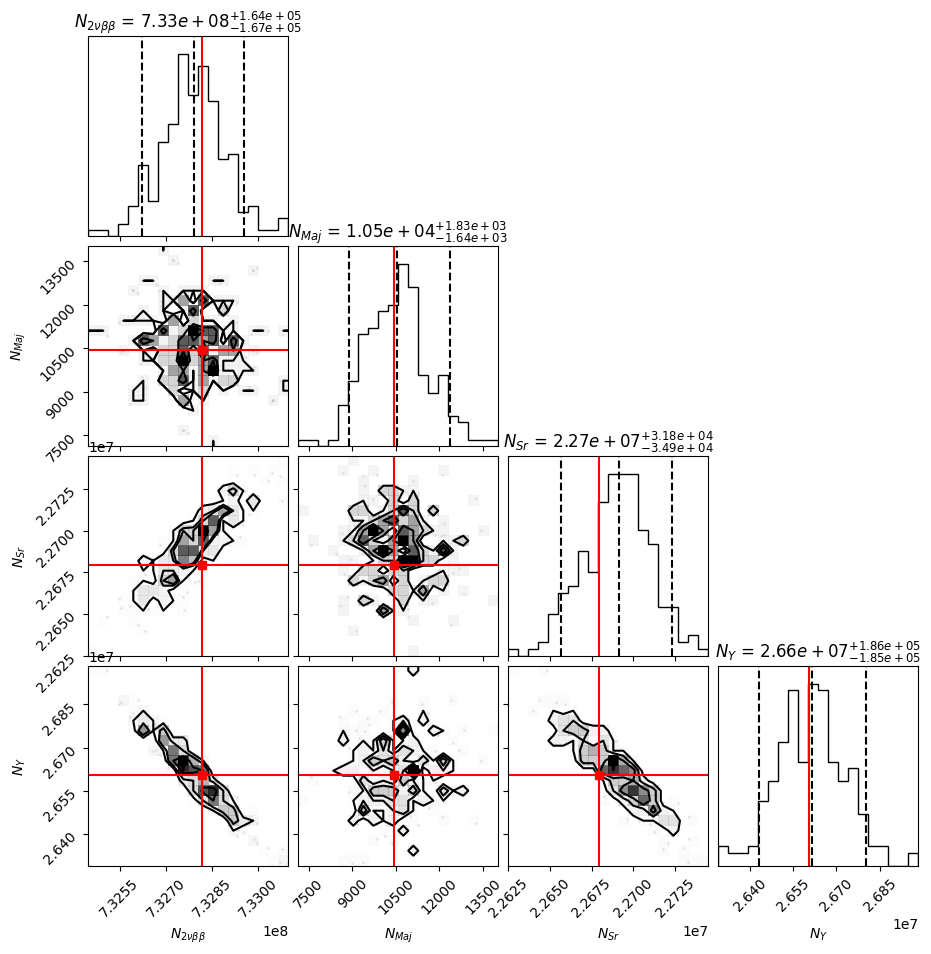

In [44]:
fig = corner.corner(
    sample[:, :4],
    labels=["$N_{2\\nu\\beta\\beta}$", "$N_{Maj}$", "$N_{Sr}$", "$N_{Y}$"],
    truths=[N_double_bb, N_majoron, N_sr_beta_rlz, N_y_beta_rlz],
    truth_color="red",
    show_titles=True,
    title_fmt=".2e",
    quantiles=[0.05, 0.5, 0.95],
)
corner.overplot_lines(fig, [None, None, N_sr_y_beta_mean, N_sr_y_beta_mean], color="orange", linestyle="--")

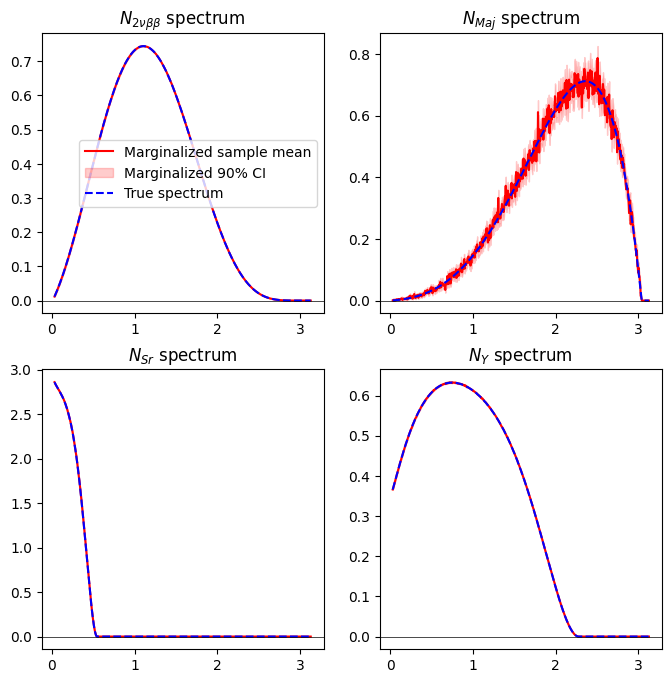

In [45]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))
axes = axes.flatten()
for component_idx, ax in enumerate(axes):
    true_pdf = [double_bb, majoron, sr_beta, y_beta][component_idx]
    pdf_sample = params_to_pdf(
        sample[
            :, 4 + component_idx * spectrum_len : 4 + (component_idx + 1) * spectrum_len
        ]
    )
    pdf_mean = np.mean(pdf_sample, axis=0)
    pdf_lower_q = np.quantile(pdf_sample, q=0.05, axis=0)
    pdf_upper_q = np.quantile(pdf_sample, q=0.95, axis=0)

    ax.plot(true_pdf.energy, pdf_mean, color="red", label="Marginalized sample mean")
    ax.fill_between(
        true_pdf.energy,
        pdf_lower_q,
        pdf_upper_q,
        color="red",
        alpha=0.2,
        label="Marginalized 90% CI",
    )
    ax.plot(
        true_pdf.energy,
        true_pdf.pdf,
        color="blue",
        linestyle="--",
        label="True spectrum",
    )
    ax.set_title(
        ["$N_{2\\nu\\beta\\beta}$", "$N_{Maj}$", "$N_{Sr}$", "$N_{Y}$"][component_idx]
        + " spectrum"
    )
    ax.axhline(0, color="k", linewidth=0.5)
    # ax.set_yscale("log")
    if component_idx == 0:
        ax.legend()

plt.show()